Team Members
- Yutian Wang(#85994168): Yutian contributed to data cleaning, formatting/standardization, visualization, time-series analysis using linear regression, and k-fold cross-validation.
- Ronin Cunningham(#43949676): Ronin contributed to implementing the PyTorch neural network to further analyze the weather and corn prices.
- Prayus Shrestha(#55823454): Prayus contributed to gathering the data through scraping and various APIs.
- Ebin Tomy(#44912301): Ebin contributed by writing the formal analysis and explaining each step.

# Weather Impacts on US Corn Prices

TO-DO: opening paragraph.  This study focuses on the relationship between weather and corn prices in US...

In [314]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.neural_network import MLPRegressor

%matplotlib inline

TO-DO: incorporate Prayus' data scrapping section here

TO-DO: add description for these two data sets. source? meaning of each column? 

### Data Cleaning and Formatting

In [280]:
weather_df = pd.read_csv('../data/weather_data.csv', index_col=0)
weather_df.head()

,time,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum
0,2000-03-24,12.6,-6.6,5.7,0.0
1,2000-03-25,15.0,-1.0,8.7,0.0
2,2000-03-26,18.7,2.4,11.2,0.0
3,2000-03-27,22.9,1.5,14.8,0.0
4,2000-03-28,22.8,7.2,14.8,0.0


In [281]:
weather_df.index = pd.to_datetime(weather_df["time"])
weather_df.index.name = "date"
weather_df["date"] = pd.to_datetime(weather_df.index)
weather_df = weather_df[["temperature_2m_mean", "precipitation_sum"]]
weather_df.head()

,temperature_2m_mean,precipitation_sum
date,,
2000-03-24,5.7,0.0
2000-03-25,8.7,0.0
2000-03-26,11.2,0.0
2000-03-27,14.8,0.0
2000-03-28,14.8,0.0


In [289]:
oil_df = pd.read_csv("../data/crude_oil.csv", index_col=0)
lumber_df = pd.read_csv("../data/lumber_data.csv", index_col=0)
oat_df = pd.read_csv("../data/oat_data.csv", index_col=0)
wheat_df = pd.read_csv("../data/wheat_data.csv", index_col=0)

In [290]:
corn_df = pd.read_csv("../data/corn_data.csv", index_col = 0)
corn_df.head()

,open,close,high,low
2023-04-20,636.50,626.50,637.25,622.00
2023-04-19,675.75,672.25,680.00,671.00
2023-04-18,676.00,677.50,682.50,669.75
2023-04-17,666.00,676.50,677.00,662.25
2023-04-16,635.00,634.75,635.75,634.00


In [291]:
def clean_commodity_df(df: pd.DataFrame, price_col_name: str = "price") -> pd.DataFrame: 
    """Cleans the Commodity DataFrame"""
    
    # Setting the index to be the date
    df.index = pd.to_datetime(df.index)
    df.index.name = "date"
    
    # Setting price to be the day's midpoint, and dropping unnecessary columns
    df[price_col_name] = (df["high"] + df["low"]) / 2 
    df = df[[price_col_name]]
    df = df.dropna() 

    # Sorting by date
    df = df.sort_index()
    return df

In [292]:
corn_df = clean_commodity_df(df=corn_df, price_col_name="corn_price")
corn_df.head()

,corn_price
date,
2018-04-23,377.750
2018-04-24,379.250
2018-04-25,383.875
2018-04-26,385.500
2018-04-27,387.875


In [293]:
oil_df = clean_commodity_df(df=oil_df, price_col_name="oil_price")
lumber_df = clean_commodity_df(df=lumber_df, price_col_name="lumber_price")
oat_df = clean_commodity_df(df=oat_df, price_col_name="oat_price")
wheat_df = clean_commodity_df(df=wheat_df, price_col_name="wheat_price")

In [294]:
# Merging features
X = pd.concat([oil_df, lumber_df, oat_df, wheat_df, weather_df], axis=1).dropna()
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum
date,,,,,,
2018-04-24,68.459999,551.500000,221.250,485.625,20.4,0.0
2018-04-25,67.645001,558.200012,224.375,501.125,21.7,0.0
2018-04-26,68.244999,559.800018,220.875,502.500,23.5,0.0
2018-04-27,68.000000,567.600006,220.875,506.625,21.6,0.0
2018-04-30,68.254997,575.500000,224.625,517.750,15.3,0.0


In [295]:
# Lag variables 
lags = [1, 7, 30, 84, 365] # day, week, month, 84 days = time taken for corn to grow, year

# Creating lags in df
for lag in lags: 
    X[f"temp_lag_{lag}"] = X["temperature_2m_mean"].shift(lag)
    X[f"precip_lag_{lag}"] = X["precipitation_sum"].shift(lag)

X.dropna(inplace=True)
X.head()

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365
date,,,,,,,,,,,,,,,,
2019-10-04,52.694999,364.700012,289.750,406.250,15.3,0.0,14.7,0.0,22.6,0.0,24.7,0.0,25.0,0.0,20.4,0.0
2019-10-07,53.325001,370.600006,284.500,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0
2019-10-08,52.540001,364.800003,282.750,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0
2019-10-09,53.025002,364.850006,283.000,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0
2019-10-10,52.675001,365.850006,287.125,408.750,14.2,0.0,15.0,0.0,17.2,0.0,28.1,0.0,28.4,0.0,15.3,0.0


In [296]:
# Autoregressive 
X = X.merge(corn_df, on="date")
X["AR1_corn_price"] = X["corn_price"].shift(1)
X.drop("corn_price", axis=1, inplace=True)
X.dropna(inplace=True)
X.head(3)

,oil_price,lumber_price,oat_price,wheat_price,temperature_2m_mean,precipitation_sum,temp_lag_1,precip_lag_1,temp_lag_7,precip_lag_7,temp_lag_30,precip_lag_30,temp_lag_84,precip_lag_84,temp_lag_365,precip_lag_365,AR1_corn_price
date,,,,,,,,,,,,,,,,,
2019-10-07,53.325001,370.600006,284.50,404.875,15.9,0.0,15.3,0.0,22.2,0.0,25.8,0.0,26.8,0.1,21.7,0.0,386.375
2019-10-08,52.540001,364.800003,282.75,405.500,15.7,0.0,15.9,0.0,22.5,0.0,25.0,0.0,23.2,0.0,23.5,0.0,386.375
2019-10-09,53.025002,364.850006,283.00,412.625,15.0,0.0,15.7,0.0,21.8,0.0,25.4,0.0,27.3,0.0,21.6,0.0,391.250


In [310]:
y = X.join(corn_df, how="inner")["corn_price"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Scaling inputs based on training data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [327]:
mlp = MLPRegressor((100, 100), random_state=123, max_iter=1000000)
mlp.fit(X_train, y_train)
# mlp.predict(X_test)
# mlp.predict(X_test)
# mse_nn = mean_squared_error(y_test, mlp.predict(X_test))
# print(mse_nn)

MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000000, random_state=123)

It's important to consider the time lag between the weather and corn price data. We should account for the fact that weather conditions in a given year may affect the corn harvest and therefore corn prices mse_nnthe following year. So we shift the index of corn_data backwards by 365 days and create a new column called 'shifted_price_date' with the shifted index values, then to merge the two dataframes.

In [328]:
mse_nn = mean_squared_error(y_test, mlp.predict(X_test))
print(mse_nn)

320.8440379280031


In [236]:
# corn_data['shifted_price_date'] = corn_data.index - pd.DateOffset(years=1)
# corn_data = corn_data.reset_index()
# merged_data = pd.merge(corn_data, weather_data, left_on='shifted_price_date', right_on='weather_date')
# merged_data = merged_data[['corn_price_date', 'avg_price', 'temperature_2m_mean', 'precipitation_sum']]
# merged_data = merged_data.set_index('corn_price_date')
# merged_data.head()

### Data Standardization

As temperature, precipitation, and price are on different scales, we standardize them to make it easier for comparison. Variables that have large values, such as temperature or precipitation, can dominate the analysis if they are not standardized.

In [23]:
# Standardize the data
scaler = StandardScaler()
merged_data_scaled = pd.DataFrame(scaler.fit_transform(merged_data), columns=merged_data.columns, index=merged_data.index)
merged_data_scaled.head()

,avg_price,temperature_2m_mean,precipitation_sum
corn_price_date,,,
2018-04-23,-0.809717,0.481661,-0.17049
2018-04-24,-0.799452,0.309092,-0.17049
2018-04-25,-0.767800,0.414134,-0.17049
2018-04-26,-0.756680,0.541685,-0.17049
2018-04-27,-0.740426,0.391625,-0.17049


### Trial Plotting

Text(0.5, 1.0, 'Corn Average Price Overview')

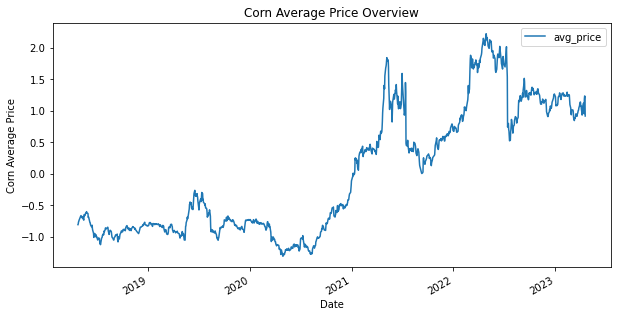

In [24]:
# plot the time-series
merged_data_scaled.plot(y='avg_price', figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Corn Average Price')
plt.title('Corn Average Price Overview')

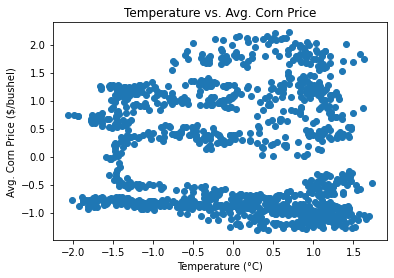

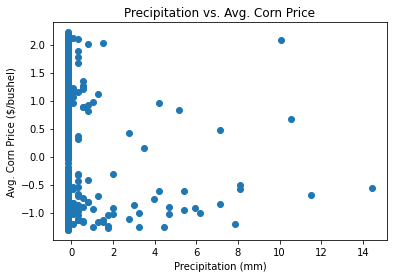

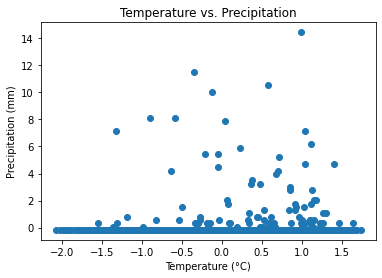

In [25]:
plt.scatter(merged_data_scaled['temperature_2m_mean'], merged_data_scaled['avg_price'])
plt.xlabel('Temperature (°C)')
plt.ylabel('Avg. Corn Price ($/bushel)')
plt.title('Temperature vs. Avg. Corn Price')
plt.show()

plt.scatter(merged_data_scaled['precipitation_sum'], merged_data_scaled['avg_price'])
plt.xlabel('Precipitation (mm)')
plt.ylabel('Avg. Corn Price ($/bushel)')
plt.title('Precipitation vs. Avg. Corn Price')
plt.show()

plt.scatter(merged_data_scaled['temperature_2m_mean'], merged_data_scaled['precipitation_sum'])
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
plt.title('Temperature vs. Precipitation')
plt.show()

Based on the plots, there doesn't seem to be a strong correlation between temperature and precipitation with corn prices. It's also possible that the relationship between weather and corn prices is more complex than a simple linear relationship, and may require further analysis to uncover.

In [26]:
corr_matrix = merged_data_scaled[['avg_price', 'temperature_2m_mean', 'precipitation_sum']].corr()
print(corr_matrix)

                     avg_price  temperature_2m_mean  precipitation_sum
avg_price             1.000000            -0.077689          -0.052772
temperature_2m_mean  -0.077689             1.000000           0.053488
precipitation_sum    -0.052772             0.053488           1.000000


<AxesSubplot:>

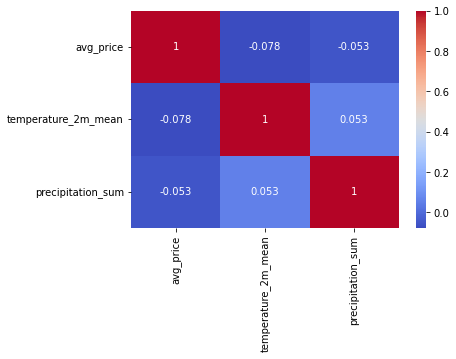

In [27]:
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

### Time Series

Using lags of 30 days and 60 days to capture any possible autocorrelation, without overfitting the model or introducing too much noise. 

In [28]:
# create lagged variables
merged_data_scaled['temp_lag1'] = merged_data_scaled['temperature_2m_mean'].shift(30)
merged_data_scaled['temp_lag2'] = merged_data_scaled['temperature_2m_mean'].shift(60)
merged_data_scaled['precip_lag1'] = merged_data_scaled['precipitation_sum'].shift(30)
merged_data_scaled['precip_lag2'] = merged_data_scaled['precipitation_sum'].shift(60)
merged_data_scaled = merged_data_scaled.dropna()

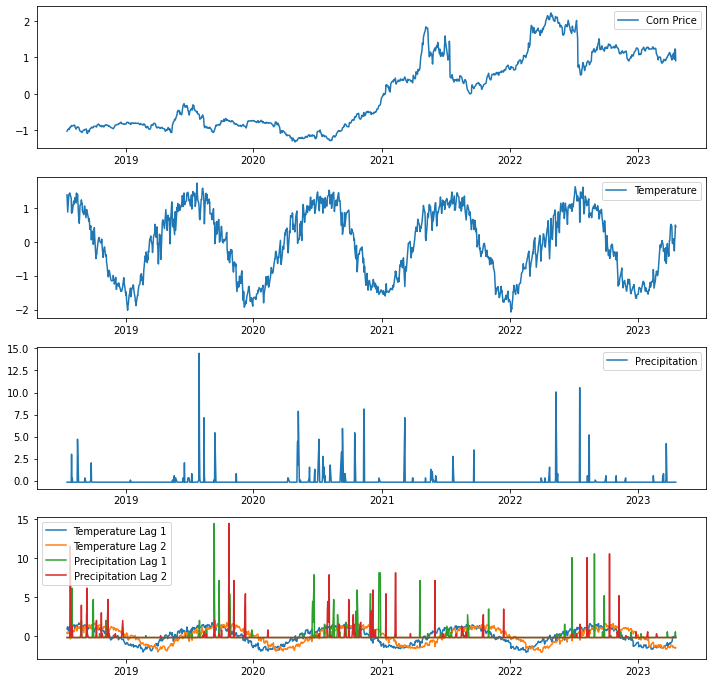

In [29]:
# Plot the merged data
fig, axs = plt.subplots(4, figsize=(12, 12))
axs[0].plot(merged_data_scaled.index, merged_data_scaled['avg_price'], label='Corn Price')
axs[0].legend()
axs[1].plot(merged_data_scaled.index, merged_data_scaled['temperature_2m_mean'], label='Temperature')
axs[1].legend()
axs[2].plot(merged_data_scaled.index, merged_data_scaled['precipitation_sum'], label='Precipitation')
axs[2].legend()
axs[3].plot(merged_data_scaled.index, merged_data_scaled['temp_lag1'], label='Temperature Lag 1')
axs[3].plot(merged_data_scaled.index, merged_data_scaled['temp_lag2'], label='Temperature Lag 2')
axs[3].plot(merged_data_scaled.index, merged_data_scaled['precip_lag1'], label='Precipitation Lag 1')
axs[3].plot(merged_data_scaled.index, merged_data_scaled['precip_lag2'], label='Precipitation Lag 2')
axs[3].legend()
plt.show()

### Linear Regression Analysis

In [30]:
X = merged_data_scaled[['temp_lag1', 'temp_lag2', 'precip_lag1', 'precip_lag2']]
y = merged_data_scaled['avg_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print('Coefficients:', lr_model.coef_)
print('Intercept:', lr_model.intercept_)

Coefficients: [-0.04319238 -0.17769309 -0.01539276 -0.02725324]
Intercept: 0.04842365407084265


In [31]:
# make predictions on test data
y_pred = lr_model.predict(X_test)

train_rmse = np.sqrt(np.mean((lr_model.predict(X_train) - y_train) ** 2))
test_rmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

Train RMSE: 0.9798776701630971
Test RMSE: 0.9949254797032723


TO-DO: add some discussions here

### Cross-Validation

In [32]:
lr2 = LinearRegression()
X = merged_data_scaled.drop('avg_price', axis=1)
y = merged_data_scaled['avg_price']

mse_scores = -cross_val_score(lr2, X, y, cv=5, scoring='neg_mean_squared_error')

print(f"Average MSE: {mse_scores.mean():.4f}, Standard deviation: {mse_scores.std():.4f}")

Average MSE: 1.4687, Standard deviation: 0.5466
